# Using a trained SuperRetina for retinal image registration

## Environment
+ Ubuntu 18.04.5 LTS
+ Python 3.8.8
+ conda install pytorch==1.8.2 torchvision==0.9.2 -c pytorch
+ See requirements.txt for other python packages

In [1]:
import os
os.chdir("..")

import configparser
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

from common.common_util import pre_processing, simple_nms, remove_borders, \
    sample_keypoint_desc
from model.super_retina import SuperRetina
from PIL import Image
import yaml

## Step 1. Read registration config

In [5]:
config_path = 'config/test.yaml'
if os.path.exists(config_path):
    with open(config_path) as f:
        config = yaml.safe_load(f)
else:
    raise FileNotFoundError("Config File doesn't Exist")


predict_config = config['PREDICT']

# SuperRetina config
device = predict_config['device']
device = torch.device(device if torch.cuda.is_available() else "cpu")

model_save_path = predict_config['model_save_path']
nms_size = predict_config['nms_size']
nms_thresh = predict_config['nms_thresh']
knn_thresh = predict_config['knn_thresh']

# Image config
model_image_width = predict_config['model_image_width']
model_image_height = predict_config['model_image_height']

# If show
show_image = True
show_keypoint = True
show_match = True
show_registration = True

In [6]:
# manual input
query_path = './data/samples/query.jpg'
refer_path = './data/samples/refer.jpg'

## Step 2. Load SuperRetina Model

In [7]:
checkpoint = torch.load(model_save_path, map_location=device)
model = SuperRetina()
model.load_state_dict(checkpoint['net'])
model.to(device)

knn_matcher = cv2.BFMatcher(cv2.NORM_L2)

image_transformer = transforms.Compose([
    transforms.Resize((model_image_height, model_image_width)),
    transforms.ToTensor()
])

## Step 3. Load a query image and a reference image

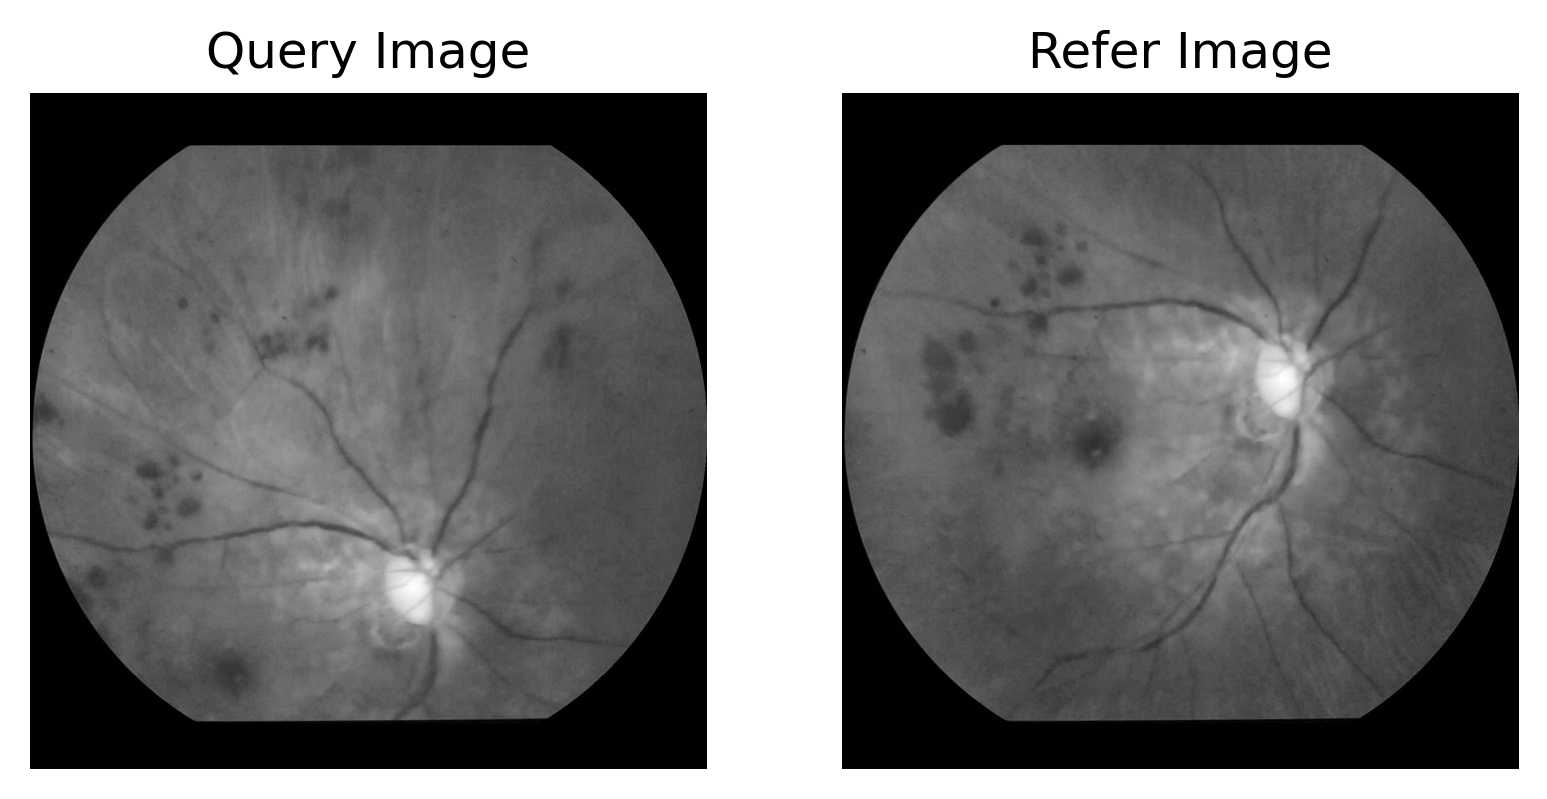

In [8]:
query_image = cv2.imread(query_path, cv2.IMREAD_COLOR)
refer_image = cv2.imread(refer_path, cv2.IMREAD_COLOR)

assert query_image.shape == refer_image.shape

image_height, image_width = refer_image.shape[:2]

# Use the green channel as model input
query_image = query_image[:, :, 1]
query_image = pre_processing(query_image)

refer_image = refer_image[:, :, 1]
refer_image = pre_processing(refer_image)

query_image = (query_image * 255).astype(np.uint8)
refer_image = (refer_image * 255).astype(np.uint8)

# scaled image size
query_tensor = image_transformer(Image.fromarray(query_image))
refer_tensor = image_transformer(Image.fromarray(refer_image))

if show_image:
    plt.figure(dpi=300)
    plt.subplot(121)
    plt.axis('off')
    plt.title("Query Image")
    plt.imshow(query_image, 'gray')
    plt.subplot(122)
    plt.axis('off')
    plt.title("Refer Image")
    plt.imshow(refer_image, 'gray')
    plt.show()
    plt.close()

## Step 4. SuperRetina keypoint detection and description.

In [9]:
# Input a batch with two images to SuperRetina 
def model_run(query_tensor, refer_tensor):
    inputs = torch.cat((query_tensor.unsqueeze(0), refer_tensor.unsqueeze(0)))
    inputs = inputs.to(device)

    with torch.no_grad():
        detector_pred, descriptor_pred = model(inputs)

    scores = simple_nms(detector_pred, nms_size)

    b, _, h, w = detector_pred.shape
    scores = scores.reshape(-1, h, w)

    keypoints = [
        torch.nonzero(s > nms_thresh)
        for s in scores]

    scores = [s[tuple(k.t())] for s, k in zip(scores, keypoints)]

    # Discard keypoints near the image borders
    keypoints, scores = list(zip(*[
        remove_borders(k, s, 4, h, w)
        for k, s in zip(keypoints, scores)]))

    keypoints = [torch.flip(k, [1]).float().data for k in keypoints]

    descriptors = [sample_keypoint_desc(k[None], d[None], 8)[0].cpu().data
                   for k, d in zip(keypoints, descriptor_pred)]
    keypoints = [k.cpu() for k in keypoints]
    return keypoints, descriptors

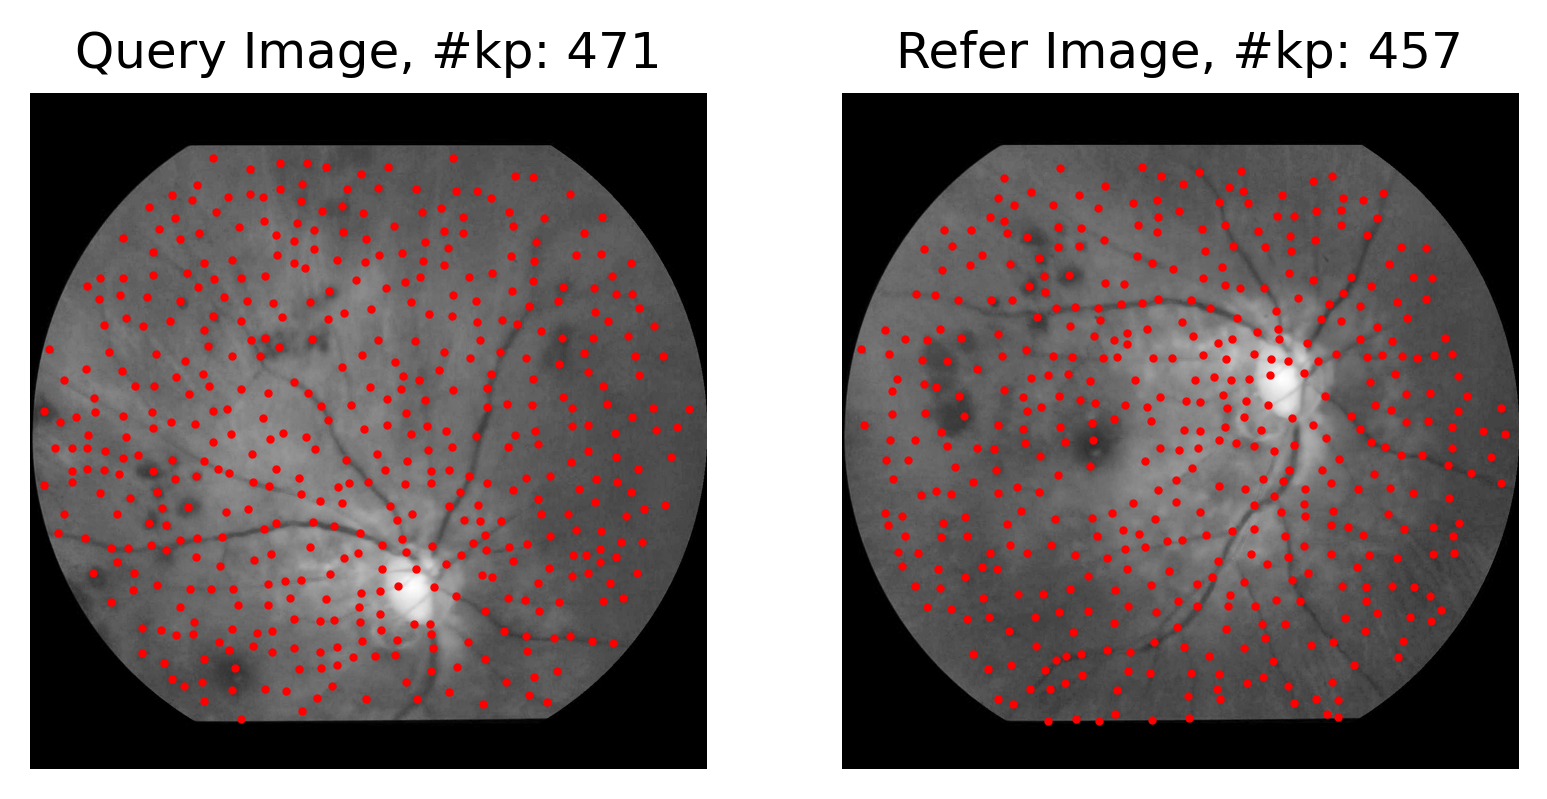

In [10]:
keypoints, descriptors = model_run(query_tensor, refer_tensor)

query_keypoints, refer_keypoints = keypoints[0], keypoints[1]
query_desc, refer_desc = descriptors[0].permute(1, 0).numpy(), descriptors[1].permute(1, 0).numpy()

# mapping keypoints to scaled keypoints
cv_kpts_query = [cv2.KeyPoint(int(i[0] / model_image_width * image_width),
                              int(i[1] / model_image_height * image_height), 30)  # 30 is keypoints size, which can be ignored
                 for i in query_keypoints]
cv_kpts_refer = [cv2.KeyPoint(int(i[0] / model_image_width * image_width),
                              int(i[1] / model_image_height * image_height), 30)
                 for i in refer_keypoints]

if show_keypoint:
    query_np = np.array([kp.pt for kp in cv_kpts_query])
    refer_np = np.array([kp.pt for kp in cv_kpts_refer])

    plt.figure(dpi=300)
    plt.subplot(121)
    plt.axis('off')
    plt.title("Query Image, #kp: {}".format(len(cv_kpts_query)))
    plt.imshow(query_image, 'gray')
    plt.scatter(query_np[:, 0], query_np[:, 1], s=1, c='r')
    plt.subplot(122)
    plt.axis('off')
    plt.title("Refer Image, #kp: {}".format(len(cv_kpts_refer)))
    plt.imshow(refer_image, 'gray')
    plt.scatter(refer_np[:, 0], refer_np[:, 1], s=1, c='r')
    plt.show()
    plt.close()

## Step 5. Keypoint matching

In [11]:
def drawMatches(imageA, imageB, kpsA, kpsB, matches, status):
    # initialize the output visualization image
    (hA, wA) = imageA.shape[:2]
    (hB, wB) = imageB.shape[:2]
    vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
    if len(imageA.shape) == 2:
        imageA = cv2.cvtColor(imageA, cv2.COLOR_GRAY2RGB)
        imageB = cv2.cvtColor(imageB, cv2.COLOR_GRAY2RGB)

    vis[0:hA, 0:wA] = imageA
    vis[0:hB, wA:] = imageB

    # loop over the matches
    for (match, _), s in zip(matches, status):
        trainIdx, queryIdx = match.trainIdx, match.queryIdx
        # only process the match if the keypoint was successfully
        # matched
        if s == 1:
            # draw the match
            ptA = (int(kpsA[queryIdx].pt[0]), int(kpsA[queryIdx].pt[1]))
            ptB = (int(kpsB[trainIdx].pt[0]) + wA, int(kpsB[trainIdx].pt[1]))
            cv2.line(vis, ptA, ptB, (0, 255, 0), 2)

        # return the visualization
    return vis 

In [12]:
goodMatch = []
status = []
try:
    matches = knn_matcher.knnMatch(query_desc, refer_desc, k=2)
    for m, n in matches:
        if m.distance < knn_thresh * n.distance:
            goodMatch.append(m)
            status.append(True)
        else:
            status.append(False)
except Exception:
    pass

## Step 6. Feature-based image registration

### Step 6.1 Find homography

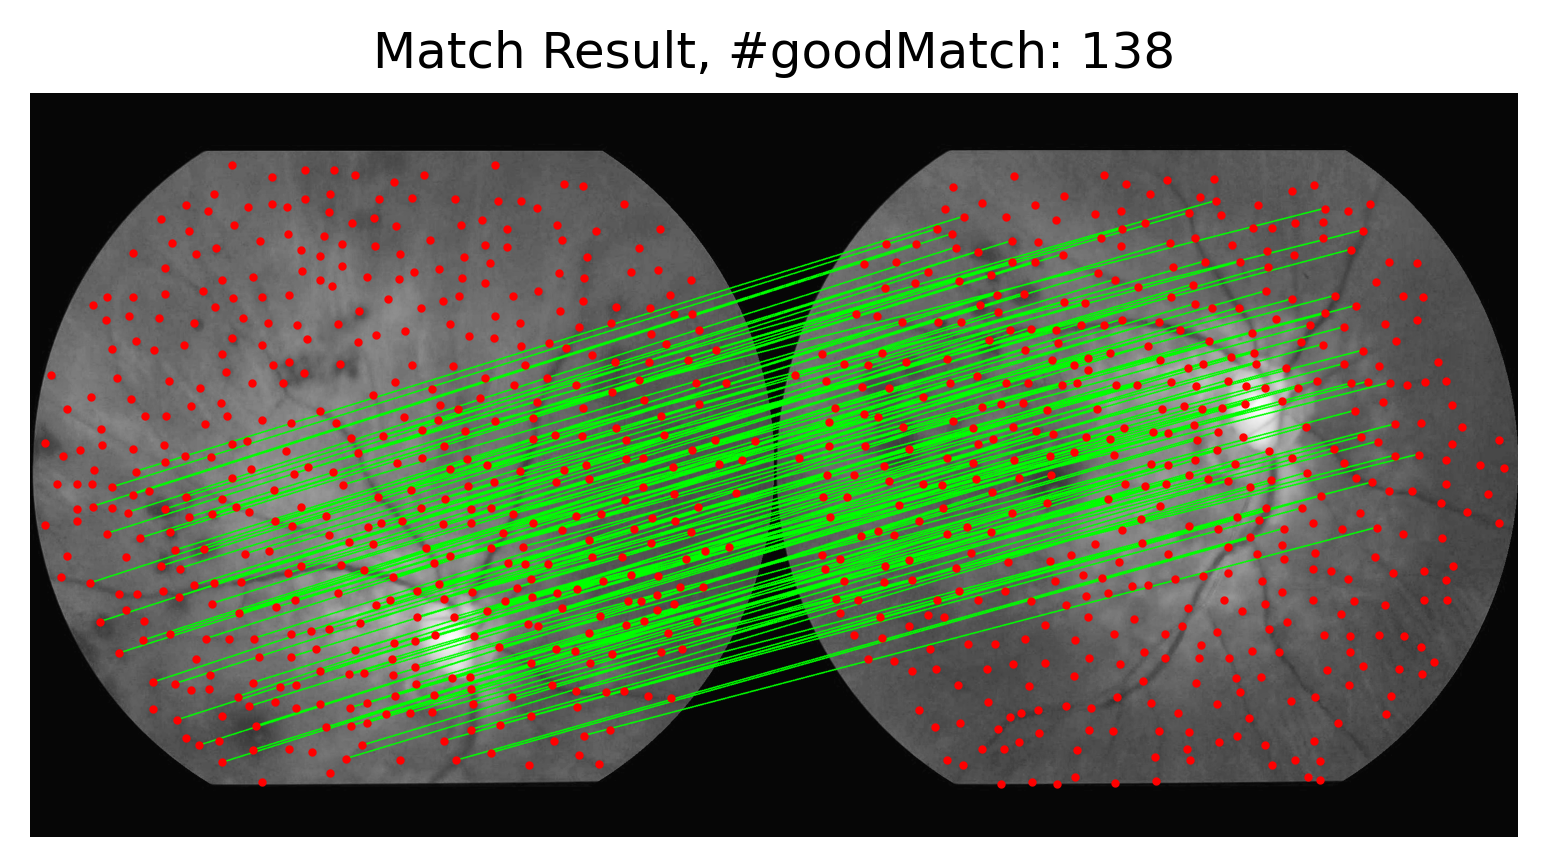

The rate of inliers: 95.833%


In [13]:
H_m = None
inliers_num_rate = 0
good = goodMatch.copy()
if len(goodMatch) >= 4:
    src_pts = [cv_kpts_query[m.queryIdx].pt for m in good]
    src_pts = np.float32(src_pts).reshape(-1, 
1, 2)
    dst_pts = [cv_kpts_refer[m.trainIdx].pt for m in good]
    dst_pts = np.float32(dst_pts).reshape(-1, 1, 2)

    H_m, mask = cv2.findHomography(src_pts, dst_pts, cv2.LMEDS)

    good = np.array(good)[mask.ravel() == 1]
    status = np.array(status)
    temp = status[status==True]
    temp[mask.ravel() == 0] = False
    status[status==True] = temp
    inliers_num_rate = mask.sum() / len(mask.ravel())
    
if show_match:
    query_np = np.array([kp.pt for kp in cv_kpts_query])
    refer_np = np.array([kp.pt for kp in cv_kpts_refer])
    refer_np[:, 0]+=query_image.shape[1]
    matched_image = drawMatches(query_image, refer_image, cv_kpts_query, cv_kpts_refer, matches, status)
    plt.figure(dpi=300)
    plt.scatter(query_np[:, 0], query_np[:, 1], s=1, c='r')
    plt.scatter(refer_np[:, 0], refer_np[:, 1], s=1, c='r')
    plt.axis('off')
    plt.title('Match Result, #goodMatch: {}'.format(len(good)))
    plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
    plt.show()
    plt.close()
    
print("The rate of inliers: {:.3f}%".format(inliers_num_rate*100))

### Step 6.2 Map the query image to the reference image

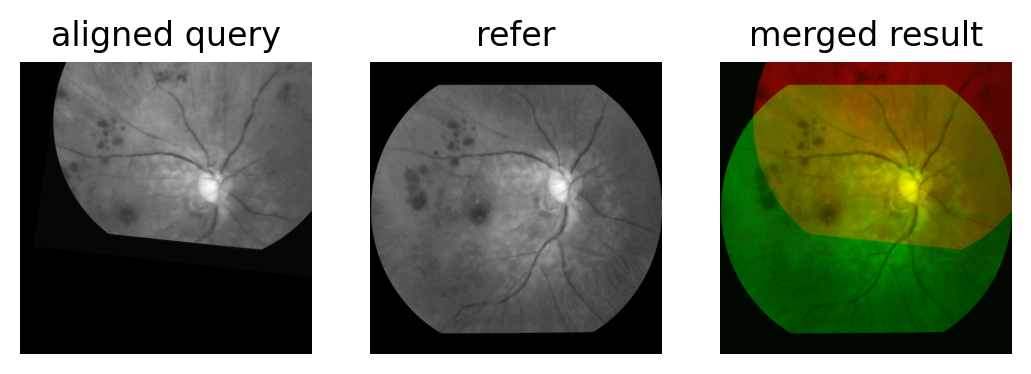

In [14]:
if H_m is not None:
    h, w = image_height, image_width
    query_align = cv2.warpPerspective(query_image, H_m, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=(0))

    merged = np.zeros((h, w, 3), dtype=np.uint8)

    if len(query_align.shape) == 3:
        query_align = cv2.cvtColor(query_align, cv2.COLOR_BGR2GRAY)
    if len(refer_image.shape) == 3:
        refer_gray = cv2.cvtColor(refer_image, cv2.COLOR_BGR2GRAY)
    else:
        refer_gray = refer_image
    merged[:, :, 0] = query_align
    merged[:, :, 1] = refer_gray

else:
    raise Exception("Failed to align the two images!")

if H_m is not None and show_registration:
    plt.figure(dpi=200)
    plt.subplot(131)
    plt.axis('off')
    plt.title('aligned query')
    plt.imshow(query_align, 'gray')
    plt.subplot(132)
    plt.axis('off')
    plt.title('refer')
    plt.imshow(refer_gray, 'gray')
    plt.subplot(133)
    plt.axis('off')
    plt.title('merged result')
    plt.imshow(merged)
    plt.show()